In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
import xgboost as xgb
from xgboost import XGBModel
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import helper

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

In [3]:
df = pd.read_csv('Ames_Housing_Price_Data.csv', 
                             index_col=0,low_memory = False)

In [17]:
train, test = helper.data_processing_wrapper(df, num_to_cat_list=[], remove_PID=False)

In [18]:
train.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,905101330,1296,90000,90,RL,72.000000,10791,Pave,0,Reg,...,0,0,0,None,Shed,500,10,2006,WD,Normal
1,909451100,1229,137000,160,RM,24.000000,1488,Pave,0,Reg,...,0,0,0,GdPrv,None,0,10,2009,WD,Normal
2,527451450,948,89000,160,RM,21.000000,1680,Pave,0,Reg,...,0,0,0,None,None,0,7,2006,WD,Normal
3,903232190,1040,123900,50,RM,52.000000,6240,Pave,0,Reg,...,0,0,0,None,None,0,5,2010,WD,Normal
4,914452120,912,156000,85,RL,61.990202,7540,Pave,0,IR1,...,192,0,0,MnPrv,None,0,6,2007,WD,Normal


In [38]:
categorical = ['MSZoning','Street','Alley','LotShape','LandContour','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
               'RoofStyle','Foundation', 'BsmtFinType1','BsmtFinType2','Heating','GarageType',
               'GarageFinish','PavedDrive','MiscFeature','SaleType','SaleCondition',
               'BedroomAbvGr', 'CentralAir', 'Utilities', 'RoofMatl', 'Exterior1st',
               'Exterior2nd', 'MasVnrType', 'Electrical', 'Functional', 'Fence'
              ]

In [39]:
[col for col in train.select_dtypes(['object','bool']).columns.to_list() if col not in categorical]

[]

In [20]:
cols_na = train.loc[:,train.isna().any(axis=0)].columns.to_list()
cols_na

[]

In [21]:
nhds = train.loc[:,['Neighborhood', 'GrLivArea']]
nhds['LogSalePrice'] = np.log(train['SalePrice'])

In [22]:
nhds = nhds.groupby('Neighborhood').agg(
    Sqft_med=pd.NamedAgg('GrLivArea',np.median),
    LogPrice_med=pd.NamedAgg('LogSalePrice',np.median)
).fillna(0)

In [23]:
weights = train.groupby('Neighborhood').count().apply(lambda x: x['PID']/len(train) ,axis=1).to_list()

In [24]:
nhds.head()

,Sqft_med,LogPrice_med
Neighborhood,,
Blmngtn,1504.0,12.180755
Blueste,1118.0,11.727633
BrDale,1030.0,11.566466
BrkSide,1203.0,11.747998
ClearCr,1721.5,12.334845


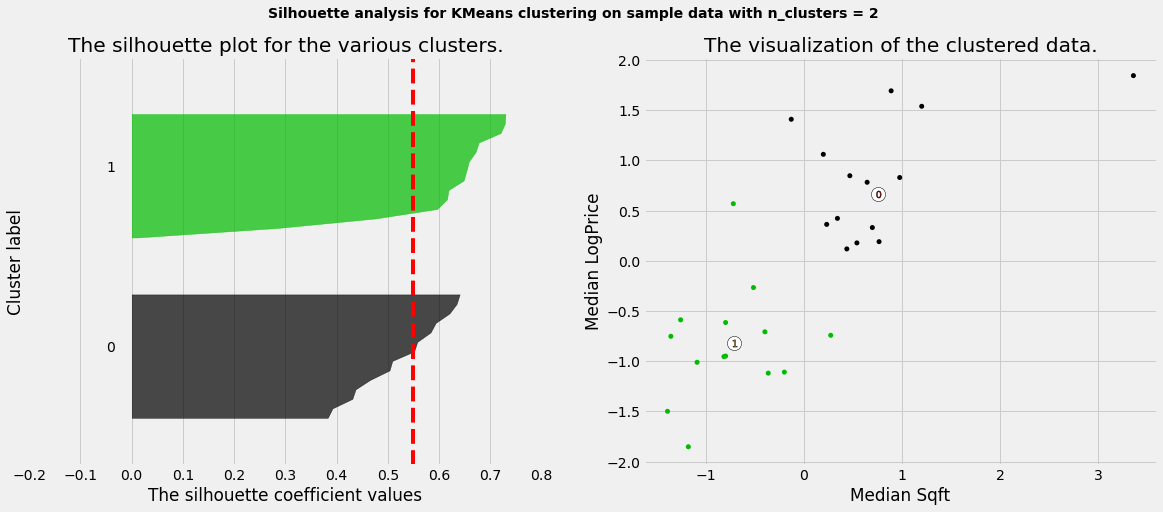

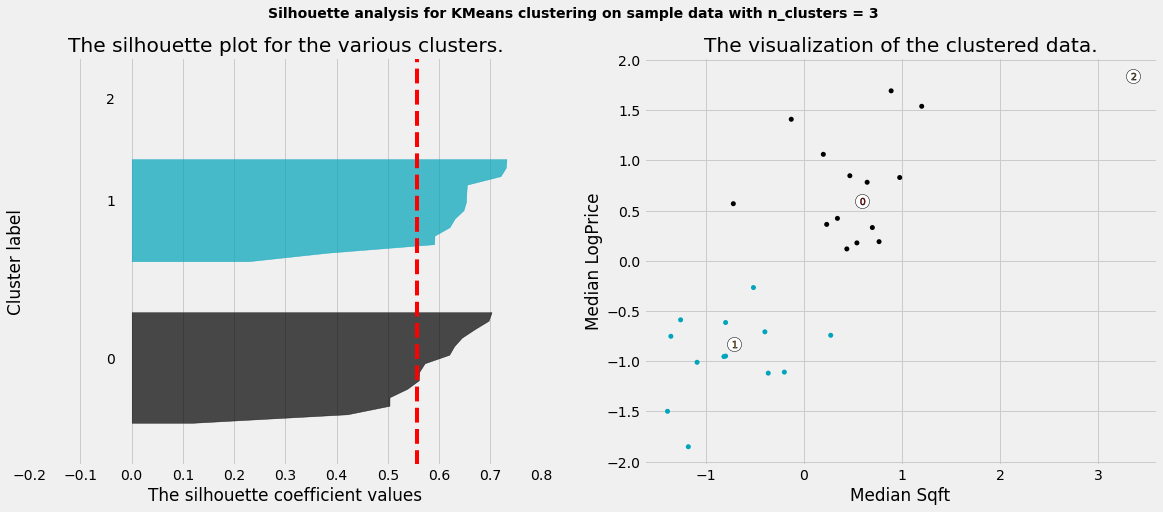

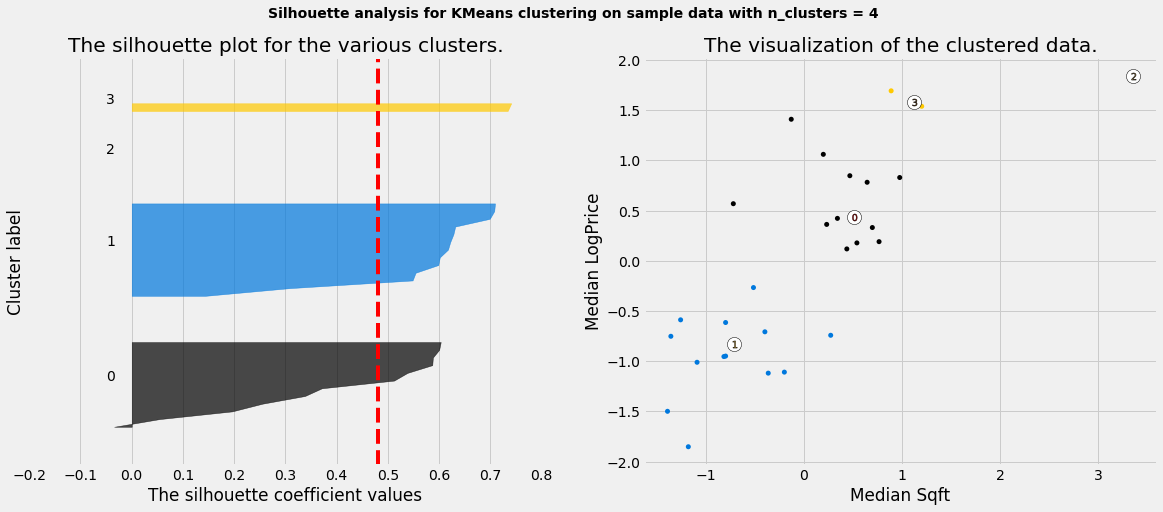

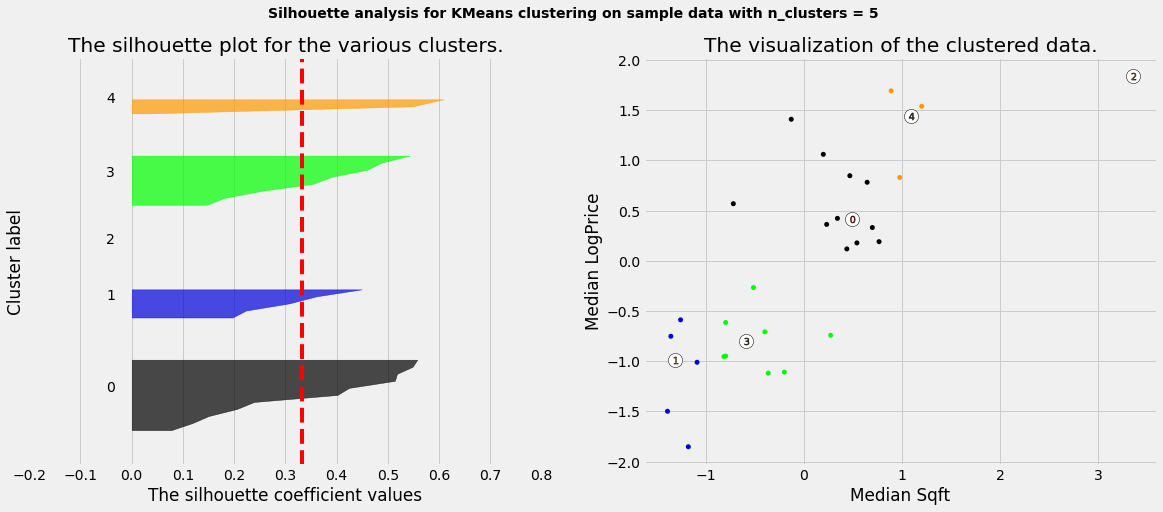

In [25]:
X = nhds
scaler = StandardScaler()
X = scaler.fit_transform(X)

inertias = []

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.2, 0.8])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 5])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X, sample_weight=weights)
    
    inertias.append(clusterer.inertia_)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 5
    
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 5
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=1,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Median Sqft")
    ax2.set_ylabel("Median LogPrice")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

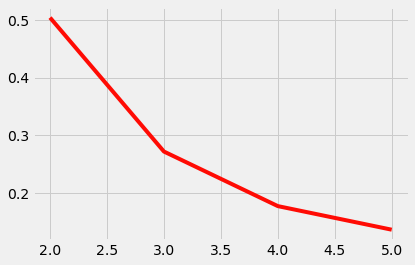

In [26]:
x = range_n_clusters
y = inertias
sns.lineplot(x=x,y=y)
plt.show()

In [27]:
clusterer = KMeans(n_clusters=3, random_state=42)
cluster_labels = clusterer.fit_predict(X)
nhds['Cluster'] = cluster_labels
nhds.sort_values('Cluster')

,Sqft_med,LogPrice_med,Cluster
Neighborhood,,,
Blmngtn,1504.0,12.180755,0
StoneBr,1696.0,12.619755,0
Somerst,1573.0,12.340759,0
SawyerW,1564.0,12.100156,0
NridgHt,1787.0,12.568940,0
NWAmes,1660.0,12.124048,0
Timber,1624.5,12.319242,0
GrnHill,1398.5,12.526341,0
Greens,1226.0,12.248806,0


In [28]:
cluster_dict = pd.DataFrame(data = {'Nhd_cluster':nhds.Cluster}, index=nhds.index).to_dict()['Nhd_cluster']

In [29]:
train['NhdCluster'] = train.apply(lambda x: cluster_dict[x['Neighborhood']], axis=1)

In [30]:
X_train = train.drop(['SalePrice', 'PID', 'TotalBsmtSF', 'GrLivArea'],axis=1)
y_train = pd.DataFrame({'LogSalePrice':np.log(train['SalePrice']), 'NhdCluster':train['NhdCluster']})

In [31]:
def multilev_selector(X, y, selector_params):
    
    score_dict = {'score_0':0, 'score_1':0, 'score_2':0}
    select_dict = {'select_0':[], 'select_1':[], 'select_2':[]}
    
    for j in range(3):
              
            X_levj = pd.DataFrame(X.loc[X['NhdCluster']==j, :].drop('NhdCluster', axis=1))
            y_levj = y.loc[y['NhdCluster']==j, :].drop('NhdCluster', axis=1)

            transformer = ColumnTransformer([("Cat", OneHotEncoder(handle_unknown = 'ignore'), categorical)], 
                                            remainder='passthrough')
            X_levj = transformer.fit_transform(X_levj)
            scaler = StandardScaler()
            X_levj = scaler.fit_transform(X_levj)
                         
            lasso = Lasso(alpha=selector_params[j])
            selector = SelectFromModel(estimator=lasso)

            X_levj = selector.fit_transform(X_levj, y_levj)

            ols = LinearRegression()
            ols.fit(X_levj,y_levj)
            if ols.score(X_levj,y_levj) > score_dict[f'score_{j}']:
                score_dict[f'score_{j}'] = ols.score(X_levj,y_levj)
                mask = selector.get_support()
                feat_names = transformer.get_feature_names()
                select_dict[f'select_{j}'] = [name for name, boo in zip(feat_names, mask) if boo]

    return score_dict, select_dict

In [40]:
selections = multilev_selector(X_train, y_train, [0.02, 0.001, 0.05])

In [41]:
selections

({'score_0': 0.9041310088000027,
  'score_1': 0.9093308893689465,
  'score_2': 0.8978075326008346},
 {'select_0': ['Cat__x0_RH',
   'Cat__x6_Gtl',
   'Cat__x21_New',
   'Cat__x24_N',
   'LotArea',
   'OverallQual',
   'YearRemodAdd',
   'ExterQual',
   'BsmtQual',
   'BsmtExposure',
   'BsmtFinSF1',
   'HeatingQC',
   '1stFlrSF',
   '2ndFlrSF',
   'HalfBath',
   'KitchenQual',
   'TotRmsAbvGrd',
   'Fireplaces',
   'FireplaceQu',
   'GarageCars',
   'GarageArea'],
  'select_1': ['Cat__x0_A (agr)',
   'Cat__x0_C (all)',
   'Cat__x0_I (all)',
   'Cat__x0_RH',
   'Cat__x0_RL',
   'Cat__x1_Grvl',
   'Cat__x2_1',
   'Cat__x2_2',
   'Cat__x3_IR2',
   'Cat__x3_IR3',
   'Cat__x4_HLS',
   'Cat__x4_Lvl',
   'Cat__x5_CulDSac',
   'Cat__x6_Sev',
   'Cat__x7_BrDale',
   'Cat__x7_BrkSide',
   'Cat__x7_Edwards',
   'Cat__x7_IDOTRR',
   'Cat__x7_MeadowV',
   'Cat__x7_Mitchel',
   'Cat__x7_OldTown',
   'Cat__x7_Sawyer',
   'Cat__x8_Artery',
   'Cat__x8_Norm',
   'Cat__x8_PosA',
   'Cat__x8_PosN',
   'C

In [42]:
X_train['NhdCluster'].value_counts()

1    969
0    852
2     50
Name: NhdCluster, dtype: int64

In [43]:
list(enumerate(categorical))

[(0, 'MSZoning'),
 (1, 'Street'),
 (2, 'Alley'),
 (3, 'LotShape'),
 (4, 'LandContour'),
 (5, 'LotConfig'),
 (6, 'LandSlope'),
 (7, 'Neighborhood'),
 (8, 'Condition1'),
 (9, 'Condition2'),
 (10, 'BldgType'),
 (11, 'HouseStyle'),
 (12, 'RoofStyle'),
 (13, 'Foundation'),
 (14, 'BsmtFinType1'),
 (15, 'BsmtFinType2'),
 (16, 'Heating'),
 (17, 'GarageType'),
 (18, 'GarageFinish'),
 (19, 'PavedDrive'),
 (20, 'MiscFeature'),
 (21, 'SaleType'),
 (22, 'SaleCondition'),
 (23, 'BedroomAbvGr'),
 (24, 'CentralAir'),
 (25, 'Utilities'),
 (26, 'RoofMatl'),
 (27, 'Exterior1st'),
 (28, 'Exterior2nd'),
 (29, 'MasVnrType'),
 (30, 'Electrical'),
 (31, 'Functional'),
 (32, 'Fence')]

In [ ]:
# param_dist = {'objective':'binary:logistic', 'n_estimators':2}

boost = XGBModel()

X_levj = pd.DataFrame(X.loc[X['NhdCluster']==1, :].drop('NhdCluster', axis=1))
y_levj = y.loc[y['NhdCluster']==1, :].drop('NhdCluster', axis=1)

transformer = ColumnTransformer([("Cat", OneHotEncoder(handle_unknown = 'ignore'), categorical)], 
                                remainder='passthrough')
X_levj = transformer.fit_transform(X_levj)

X_levj = scaler.fit_transform(X_levj)

clf.fit(X_train, y_train)

evals_result = clf.evals_result()